# Anomaly Detection

**Detect bizarre events in a not-so-bizarre manner**

## Problem Statement

Given a pattern depicting behaviour of a system, identify events that do not conform to it.

In [2]:
from IPython.display import Image

In [3]:
Image(url='https://g.twimg.com/blog/blog/image/figure_2_Photos_ChristmasEve_2013.png')

## Why?

Anomaly Detection finds applications in a variety of fields:

    1. Bank fraud detection
    2. Health system monitoring
    3. Fault/ Event detection in equipments
    4. Intrusion Detection
    5. Enhancement in user engagement
    6. Bot detection

## How?

For this talk, we'll restrict ourselves to dealing with time series data. Time series data provides a 'history' to the parameters that we are trying to model. Given that, using statistical techniques (even as simple as moving average), we can figure out if something is wrong if the behaviour of the system parameters deviates from the usual pattern.

One-dimensional data can be visualized and hence manually segregated as healthy or not.

Problems arise when we start working with multivariate time series.

**Some important things to note are:**

    1. Trend
    2. Seasonality
    

In [9]:
Image(url='https://cdn.xlstat.com/img/tutorials/hw1.gif')

## Overview of Algorithms Used

Given a sequential piece of data, we need to classify whether it is an anomaly(or failure of some component) or not. 


* Supervised
* Semi-supervised
* Unsupervised

**Problem:** When the onset of the anomaly is gradual
**Solution:** Pattern recognition

Conventionally used algorithms:

1. Rule-based classifiers
2. Feature Selection + Models like decision trees, SVM
2. Hidden markov models
3. Recurrent neural networks with long short-term memory units



# Proceeding with the model

From Jaidev Deshpande’s talk on Continuous Integration for Data Scientists at PyCon 2016, New Delhi:

>Broadly, the development and maintenance stages of a machine learning product can be broken down as follows:
> * Data Ingestion: data collection, cleaning and transforming (ETL)
> *	Feature Engineering
> *	Model Selection
> *	Training and Prediction
> *	Incorporating feedback from production into the training process


## Python Environment

Start with IPython Notebooks. People with a fetish for working on black screens can use [this dark background theme](https://github.com/powerpak/jupyter-dark-theme). Then customize matplotlib to use the 'dark_background' style for plots.

[Anaconda Distribution](https://anaconda.org/) is preferable (Miniconda works too)

### Import Libraries

In [4]:
import pandas as pd
import numpy as np
import re
import datetime 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as ss

### Set options

In [5]:
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)

## Exploratory Data Analysis

I'll be using my own dataset for this purpose. It has been cleaned and is well-structured. This data is from the sensors in a Micro Cold Storage and has variables like:

1. Room temperature + Humidity
2. Ambient temperature + Humidity
3. Door open (1/0)
4. Fans on
5. Current
6. Frequency

I'll explain a little about how the refrigeration cycle works in a while.  

FYI, I could have used a conventional dataset, with a 1-D time series or the overused Iris dataset, but the whole purpose of the talk is to show how data science can be used in non-conventional setting, for a non-data driven product -> non-IT or manufacturing industries where traditionally, data analysis had been done manually

In [6]:
f = 'original_data.csv'
df_old = pd.read_csv(f)

C:\Users\Shreya Khurana\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12,15,16,38,39,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df_old[df_old.columns[2:]].describe()

,A02,A03,A05,A06,A07,A08,A09,A11,A15,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,A29,A30,A31,A32,A33,A34,A35,A38,A39,A42,A43,A44,A45,A46,A47,A48,A49,A50
count,23684.000000,23684.000000,23684.0,23684.000000,23684.0,23684.000000,23685.000000,23684.000000,23684.000000,23684.000000,23684.0,23684.0,23684.0,23684.0,23684.0,23684.000000,23684.000000,0.0,23684.000000,0.0,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,23684.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,24.003931,16.987253,0.0,0.010640,0.0,0.077014,9.700798,18.917763,13.319845,0.284589,0.0,1.0,1.0,1.0,0.0,0.143599,0.219642,NaN,0.350152,NaN,0.213140,0.193886,0.026980,0.253082,0.204864,0.309872,0.280949,0.025925,28.372074,55.487299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.199530,6.958131,0.0,0.102603,0.0,0.266619,7.837773,24.098587,27.925055,0.603622,0.0,0.0,0.0,0.0,0.0,0.351652,0.414013,NaN,0.479764,NaN,0.409534,0.395349,0.162029,0.434787,0.403611,0.462450,0.449472,0.158914,4.024769,13.481773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,16.800000,11.600000,0.0,0.000000,0.0,0.000000,-28.500000,0.100000,0.000000,0.000000,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,6.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,7.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,9.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,30.000000,56.400000,0.0,1.000000,0.0,1.000000,91.500000,91.000000,87.000000,2.500000,0.0,1.0,1.0,1.0,0.0,2.000000,1.000000,NaN,2.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,85.500000,90.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Loading my cleaned dataset

path = 'C:\Users\Shreya Khurana\MCS_data.csv'
data = pd.read_csv(path)
data.head()

,DATETIME,DC BUS VOLTAGE,BATTERY VOLTAGE,LOAD CURRENT,HIGH PRESSURE,LOW PRESSURE,MOTOR PROTECTOR,GRID AVAILABLE,ROOM TEMP,AMB TEMP,AMB HUMIDITY,TES TEMP 1,TES TEMP 2,ROOM HUMIDITY,FREQUENCY,DRIVE CURRENT,DRIVE POWER,DRIVE FAULT,POWER,CROP,MODE,POWER INPUT,FAN VALVE,TES VALVE 1,FAN 1,CDU FAN 1,CDU FAN 2,GRID RELAY,SOLAR RELAY,COMPRESSOR,PANEL BOX FAN,HUMIDIFIER,HEATER,TANK FULL,DOOR OPEN,PRESSURE
0,2015-10-01 00:00:18,4.6,23.5,11.8,0.0,0.0,0.0,0.0,9.3,27.2,29.3,2.7,1.6,79.8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.8
1,2015-10-01 00:01:48,4.6,23.7,11.8,0.0,0.0,0.0,0.0,9.3,27.2,29.5,2.7,1.6,80.4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.8
2,2015-10-01 00:03:18,3.7,23.5,11.8,0.0,0.0,0.0,0.0,9.3,27.2,29.5,2.7,1.6,79.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.8
3,2015-10-01 00:04:48,4.6,23.7,11.8,0.0,0.0,0.0,0.0,9.4,27.2,29.3,2.9,1.6,79.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.8
4,2015-10-01 00:06:18,4.6,23.5,11.8,0.0,0.0,0.0,0.0,9.3,27.2,29.3,2.8,1.6,78.9,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27.8


One of the first things as a data analyst that you do is check whether the data you have is accurate, reliable and exhaustive.

I've cleaned this up, so you don't see any ill-formatted, NaN values etc., but data wrangling is one aspect that is essential to any kind of modelling because a great dataset + mediocre model implies great predictive accuracy.

In [6]:
data.apply(lambda x:sum(x.isnull()))

DATETIME           0
DC BUS VOLTAGE     0
BATTERY VOLTAGE    0
LOAD CURRENT       0
HIGH PRESSURE      0
LOW PRESSURE       0
MOTOR PROTECTOR    0
GRID AVAILABLE     0
ROOM TEMP          0
AMB TEMP           0
AMB HUMIDITY       0
TES TEMP 1         0
TES TEMP 2         0
ROOM HUMIDITY      0
FREQUENCY          0
DRIVE CURRENT      0
DRIVE POWER        0
DRIVE FAULT        0
POWER              0
CROP               0
MODE               0
POWER INPUT        0
FAN VALVE          0
TES VALVE 1        0
FAN 1              0
CDU FAN 1          0
CDU FAN 2          0
GRID RELAY         0
SOLAR RELAY        0
COMPRESSOR         0
PANEL BOX FAN      0
HUMIDIFIER         0
HEATER             0
TANK FULL          0
DOOR OPEN          0
PRESSURE           0
dtype: int64

In [7]:
zip(data.columns, [data[col].dtype for col in list(data.columns)])

[('DATETIME', dtype('O')),
 ('DC BUS VOLTAGE', dtype('float64')),
 ('BATTERY VOLTAGE', dtype('float64')),
 ('LOAD CURRENT', dtype('float64')),
 ('HIGH PRESSURE', dtype('float64')),
 ('LOW PRESSURE', dtype('float64')),
 ('MOTOR PROTECTOR', dtype('float64')),
 ('GRID AVAILABLE', dtype('float64')),
 ('ROOM TEMP', dtype('float64')),
 ('AMB TEMP', dtype('float64')),
 ('AMB HUMIDITY', dtype('float64')),
 ('TES TEMP 1', dtype('float64')),
 ('TES TEMP 2', dtype('float64')),
 ('ROOM HUMIDITY', dtype('float64')),
 ('FREQUENCY', dtype('float64')),
 ('DRIVE CURRENT', dtype('float64')),
 ('DRIVE POWER', dtype('float64')),
 ('DRIVE FAULT', dtype('float64')),
 ('POWER', dtype('float64')),
 ('CROP', dtype('float64')),
 ('MODE', dtype('float64')),
 ('POWER INPUT', dtype('float64')),
 ('FAN VALVE', dtype('float64')),
 ('TES VALVE 1', dtype('float64')),
 ('FAN 1', dtype('float64')),
 ('CDU FAN 1', dtype('float64')),
 ('CDU FAN 2', dtype('float64')),
 ('GRID RELAY', dtype('float64')),
 ('SOLAR RELAY', dty

** Let us check if any of the variables have a correlation with the room temperature**

In [14]:
zip(list(data.columns)[1:], [ss.pearsonr(data[col], data['ROOM TEMP'])[0] for col in list(data.columns)[1:]])

[('DC BUS VOLTAGE', -0.14958591554903336),
 ('BATTERY VOLTAGE', 0.070214621274849412),
 ('LOAD CURRENT', -0.26486040768220598),
 ('HIGH PRESSURE', nan),
 ('LOW PRESSURE', 0.061116586496371625),
 ('MOTOR PROTECTOR', nan),
 ('GRID AVAILABLE', -0.095864751692488648),
 ('ROOM TEMP', 1.0),
 ('AMB TEMP', -0.11854553463557826),
 ('AMB HUMIDITY', -0.078596612722393183),
 ('TES TEMP 1', 0.94399950480437222),
 ('TES TEMP 2', 0.95144566790502361),
 ('ROOM HUMIDITY', 0.075446805313178364),
 ('FREQUENCY', -0.41028232397489695),
 ('DRIVE CURRENT', -0.42236532480051808),
 ('DRIVE POWER', -0.41853328697225517),
 ('DRIVE FAULT', nan),
 ('POWER', nan),
 ('CROP', nan),
 ('MODE', nan),
 ('POWER INPUT', nan),
 ('FAN VALVE', -0.23709147041293144),
 ('TES VALVE 1', -0.40187736376075933),
 ('FAN 1', 0.10054416624832979),
 ('CDU FAN 1', -0.40149927673863089),
 ('CDU FAN 2', -0.42414647802829625),
 ('GRID RELAY', -0.059637375526715414),
 ('SOLAR RELAY', -0.37712624670971828),
 ('COMPRESSOR', -0.4015210831201502

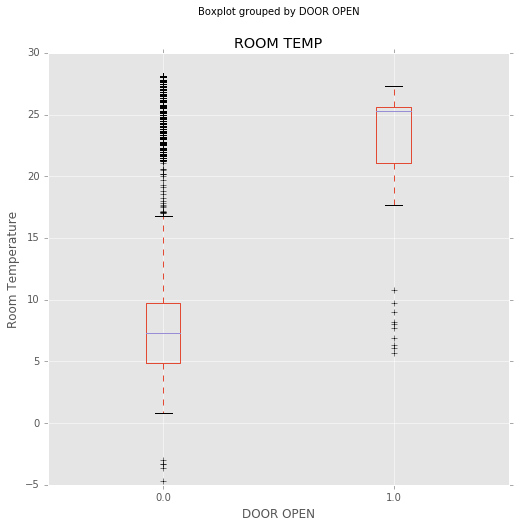

In [16]:
data.boxplot(column='ROOM TEMP',by='DOOR OPEN',figsize=(8,8) )
plt.ylabel('Room Temperature');

In [18]:
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

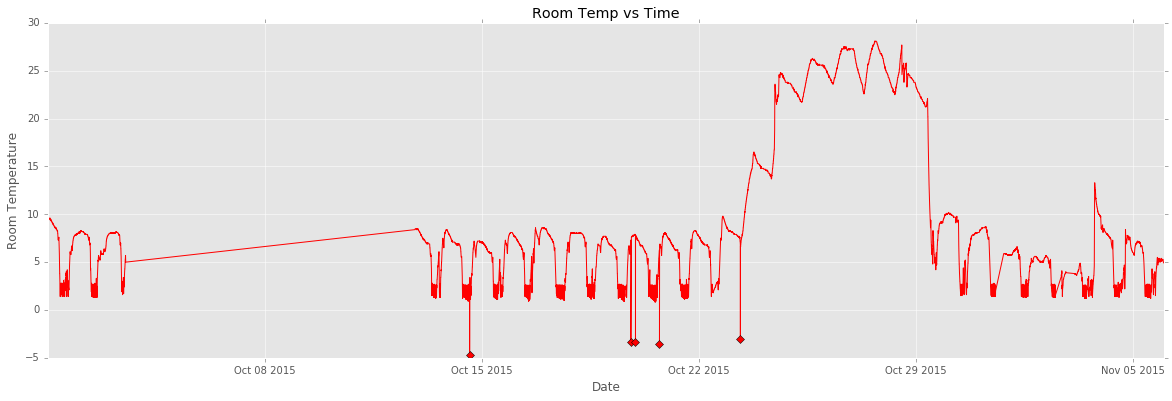

In [25]:
high = data['ROOM TEMP'][data['ROOM TEMP'] < 0].index
high = list(high)

plt.figure(figsize=(20,6))
plt.plot(data['DATETIME'], data['ROOM TEMP'], '-rD', label='Extremes', markevery= high);
plt.title('Room Temp vs Time');
plt.xlabel('Date');
plt.ylabel('Room Temperature');

Some observations:

1. Why a sudden jump from 8th Oct to 14th Oct?
2. Local vs Global anomalies
3. Gradual onset vs sudden
4. Seasonality

Let us see the distribution of the room temperature

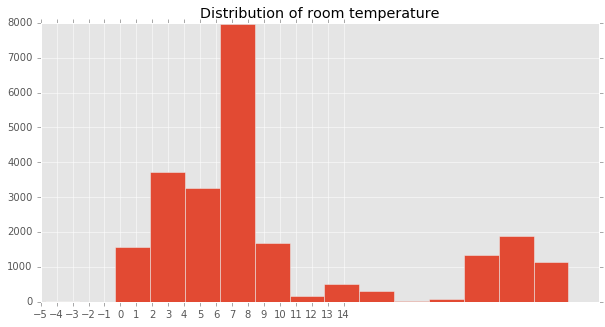

In [32]:
hist_temp = data['ROOM TEMP'].hist(bins=15, figsize=(10,5))
hist_temp.set_xticks(range(-5,15));
plt.title('Distribution of room temperature');

What if we want to find out how the room temp varies according to time each day? Does it vary across each hour? 

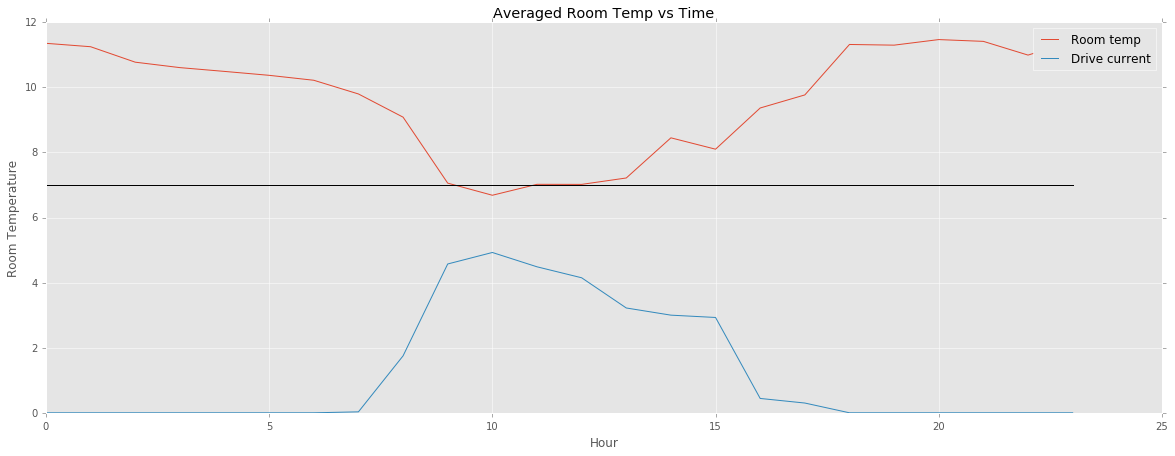

In [36]:
data['HOUR'] = data['DATETIME'].apply(lambda x: x.hour)
x = data['HOUR'].sort_values().unique()
y = data.groupby('HOUR').aggregate(np.mean)['ROOM TEMP']
drvc = data.groupby('HOUR').aggregate(np.mean)['DRIVE CURRENT']
plt.figure(figsize=(20,7))
plt.plot(list(x), y, label='Room temp')
plt.plot(list(x), drvc, label='Drive current')
plt.plot(list(x), np.ones(len(y))*7, 'k')
plt.title('Averaged Room Temp vs Time');
plt.xlabel('Hour');
plt.ylabel('Room Temperature');
plt.legend();

## Leak Detection in a Micro cold storage

We need to know the context in which we're working.

Why do we need this? To have an intuition about the variables we are working with.

To study a leak, we need to look at the data from October 23rd to Nov 1st.

Let us look at three variables:

   * Room temp
   * Low Pressure
   * Drive current 

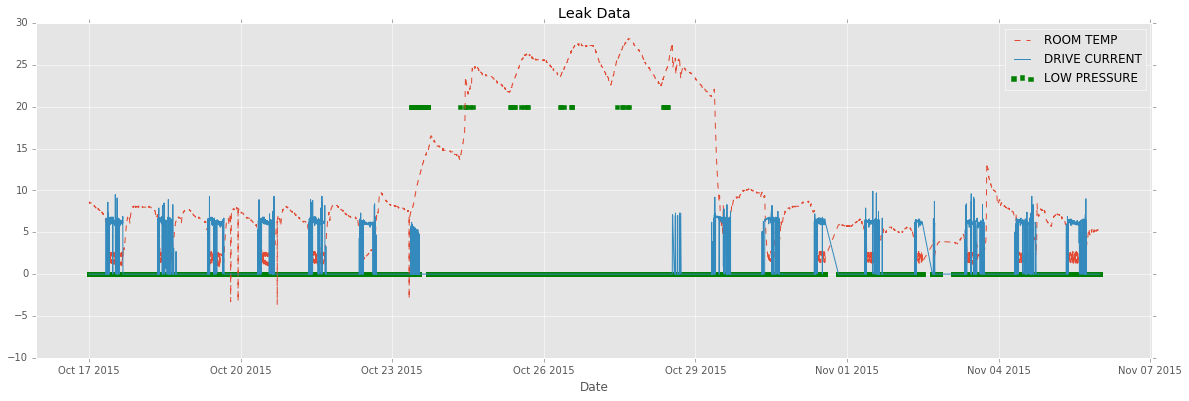

In [61]:
df_leak = data[data['DATETIME'] > datetime.date(2015, 10, 17)]

plt.figure(figsize=(20,6))
plt.plot(df_leak['DATETIME'], df_leak['ROOM TEMP'], '--')
plt.plot(df_leak['DATETIME'], df_leak['DRIVE CURRENT']);
plt.scatter(list(df_leak['DATETIME']), df_leak['LOW PRESSURE']*20, marker=',', s=20, color='g')
plt.title('Leak Data');
plt.xlabel('Date');
plt.legend();

Our Drive current goes down, we hit an LP and so we know that we have a leak.

But to predict it beforehand is where we need the power of machine learning, that can learn patterns across time. This is also where Recurrent Neural Networks work their magic.